In [2]:
import csv
import cv2
import numpy as np
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras import regularizers
import math
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


In [3]:
samples = []
with open('data/data/driving_log.csv') as csvfile:
    #csvlines = csvfile.readlines()  # if we use this method then comment below 3 lines and replace samples by csvlines
    reader = csv.reader(csvfile)
    for line in reader:
        if float(line[3])>0.0001 or float(line[3])<-0.0001:
            samples.append(line)
        else:
            select_prob = np.random.random()
            if select_prob > 0.9:
                samples.append(line)
            
        #samples.append(line)
        
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print (len(samples), len(train_samples), len(validation_samples), samples[550])
a= np.array(samples)

3801 3040 761 ['IMG/center_2016_12_01_13_34_35_526.jpg', 'IMG/left_2016_12_01_13_34_35_526.jpg', 'IMG/right_2016_12_01_13_34_35_526.jpg', '0.1287396', '0.9855326', '0', '30.18612']


[-0.9426954  -0.86498758 -0.78727977 -0.70957195 -0.63186414 -0.55415632
 -0.4764485  -0.39874069 -0.32103287 -0.24332506 -0.16561724 -0.08790942
 -0.01020161  0.06750621  0.14521402  0.22292184  0.30062966  0.37833747
  0.45604529  0.5337531   0.61146092  0.68916874  0.76687655  0.84458437
  0.92229218  1.        ] [  4   1   2   2   4  16  43  40 144 168 476 625 861 509 567 119 160  21
  25   6   5   1   0   0   2   1]


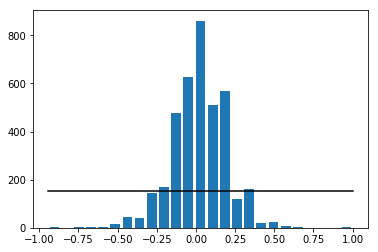

In [4]:
# print a histogram to see which steering angle ranges are most overrepresented
a_angles = a[:,3].astype(np.float)
num_bins = 25
avg_samples_per_bin = len(a)/num_bins
hist, bins = np.histogram(a_angles, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(a_angles), np.max(a_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

hist = np.concatenate((hist, [1]))  # because no of bins are 26 (0 to 25), but no of hist were 25.(see print(bins, hist) below)
print(bins, hist)

In [5]:
#car_images = []
#steering_angles = []
i=0

def process_image(image):
    
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image, (64, 64))
    
    #image2 = np.zeros(image.shape, dtype='u1')
    #image2 = brightness_process_image(image, image2)
    
    return image

(64, 64, 3) (64, 10, 3)


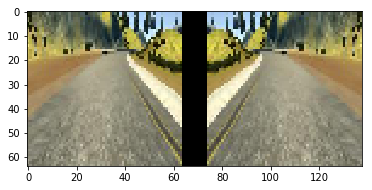

In [6]:
#Sample processing on first image in csv file
path = 'data/data/' # fill in the path to your training IMG directory

divider = np.asarray(np.zeros((64,10,3), dtype='u1'))

#img_center1 = process_image(np.asarray(Image.open(path+csvlines[550][0:38]))) #line[x][0:38], x is row number, [0:38] is characters of first coulmn of that row..
img_center1 = process_image(np.asarray(Image.open(path+samples[250][0])))  #line[x][1], x is row number, [0] is 0th coulmn of that row..
print(img_center1.shape, divider.shape)
img_center1_flipped = np.fliplr(img_center1)
res1 = np.hstack((img_center1, divider, img_center1_flipped))
plt.imshow(res1)


In [11]:
def Augmentation(row, car_images, steering_angles):
    steering_center = float(row[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.12     # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    
    # read in images from center, left and right cameras
    path = 'data/data/' # fill in the path to your training IMG directory
    
    img_center = process_image(np.asarray(Image.open(path+row[0])))
    img_center_flipped = np.fliplr(img_center)
    img_left = process_image(np.asarray(Image.open(path+row[1])))
    img_left_flipped = np.fliplr(img_left)
    img_right = process_image(np.asarray(Image.open(path + row[2])))
    img_right_flipped = np.fliplr(img_right)
    
    # add images and angles to data set
    car_images.append(img_center)
    car_images.append(img_center_flipped)
    car_images.append(img_left)
    car_images.append(img_left_flipped)
    car_images.append(img_right)
    car_images.append(img_right_flipped)
    steering_angles.append(steering_center)
    steering_angles.append(-steering_center)
    steering_angles.append(steering_left)
    steering_angles.append(-steering_left)
    steering_angles.append(steering_right)
    steering_angles.append(-steering_right)

In [ ]:
def Augmentation_None(row, car_images, steering_angles):
    steering_center = float(row[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.12     # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    
    # read in images from center, left and right cameras
    path = 'data/data/' # fill in the path to your training IMG directory
    
    img_center = process_image(np.asarray(Image.open(path+row[0])))
    img_center_flipped = np.fliplr(img_center)
    img_left = process_image(np.asarray(Image.open(path+row[1])))
    img_left_flipped = np.fliplr(img_left)
    img_right = process_image(np.asarray(Image.open(path + row[2])))
    img_right_flipped = np.fliplr(img_right)
    
    # add images and angles to data set
    car_images.append(img_center)
    car_images.append(img_center_flipped)
    car_images.append(img_left)
    car_images.append(img_left_flipped)
    car_images.append(img_right)
    car_images.append(img_right_flipped)
    steering_angles.append(steering_center)
    steering_angles.append(-steering_center)
    steering_angles.append(steering_left)
    steering_angles.append(-steering_left)
    steering_angles.append(steering_right)
    steering_angles.append(-steering_right)

In [16]:
def generator(samples, augment=True, batch_size=32):
    num_samples = int(len(samples)/3)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            car_images = []
            steering_angles = []

            for row in batch_samples:
                Augmentation(row, car_images, steering_angles)

            # trim image to only see section with road
            X_train = np.array(car_images)
            y_train = np.array(steering_angles)
            #print(X_train.shape, y_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)

In [17]:
# compile and train the model using the generator function
train_generator = generator(train_samples, augment=True, batch_size=32)
validation_generator = generator(validation_samples, augment=False, batch_size=32)

In [19]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(64,64,3)))
# layer 1 output shape is 32x32x32
model.add(Convolution2D(32, 5, 5, input_shape=(64, 64, 3), subsample=(2, 2), border_mode="same"))
model.add(ELU())
# layer 2 output shape is 15x15x16
model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
model.add(MaxPooling2D((2, 2), border_mode='valid'))
# layer 3 output shape is 13x13x16
model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
# Flatten the output
model.add(Flatten())
# layer 4
model.add(Dense(2704))
model.add(Dropout(.3))
model.add(ELU())
# layer 5          
model.add(Dense(1024))
model.add(Dropout(.3))
model.add(ELU())
# layer 6
model.add(Dense(512))
model.add(ELU())
# Finally a single output, since this is a regression problem
model.add(Dense(1))
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 64, 64, 3)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 32, 32, 32)    2432        lambda_2[0][0]                   
____________________________________________________________________________________________________
elu_6 (ELU)                      (None, 32, 32, 32)    0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 30, 30, 16)    4624        elu_6[0][0]                      
___________________________________________________________________________________________

In [ ]:
model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train,validation_split=0.2, shuffle=True, nb_epoch=7)
history_object = model.fit_generator(train_generator, samples_per_epoch= \
            len(train_samples)*2, validation_data=validation_generator, \
            nb_val_samples=len(validation_samples)*2, nb_epoch=10, verbose=1)          #https://keras.io/models/sequential/#fit_generator

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model_test.h5')
print(model.summary())

Epoch 1/10
